# Machine Learning in Python - Project 1

Due Friday, April 9th by 5 pm UK local time.

Abu Mazhar, Adrian Lee, Elliot Kovanda, Gianluca Bianchi.

## 0. Setup

In [1]:
# Install required packages
!pip install -q -r requirements.txt

In [2]:
# Add any additional libraries or submodules below

# Display plots inline
%matplotlib inline

# Data libraries
import pandas as pd
import numpy as np
import scipy

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.lines import Line2D

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.tree import export_text
from sklearn.metrics import confusion_matrix
from sklearn import utils
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score


# Other modules
import scipy.stats as st

In [3]:
# Load data
d = pd.read_csv("hotel.csv") 

## 1. Introduction
Hotel rooms are typically booked well in advance of the visit. The lead-time between the booking and scheduled stay is usually many months long. While this long planning horizon may allow hotel owners to adjust their operations and pricing optimally, the opposite is often the case: Hotels hold back rooms for extended periods, however, a significant proportion of customers cancel short-term. Since hotel rooms are essentially perishable products with no value once each day has passed, any cancellations that cannot be filled constitute lost revenue for the hotel. Predicting which customers are likely to cancel their booking would allow hotels to respond effectively and gain a competitive advantage. 
 
In this report we developed a machine learning model which predicts whether a customer is likely to cancel their booking. The hotel bookings data set published by Antonio, Almeida and Nunes (2019) was used to train and evaluate the model. This data contains around 120,000 individual bookings made at two Portuguese hotels between 2015 and 2017. The data is labelled, showing for each booking whether or not it was cancelled. Additionally, the data contains 29 features such as the price and time of the booking, details on the guests, their requests and the sales channels to name a few. The challenge is to develop a classification model that has high performance but remains explainable, thereby allowing the hotel owners to respond to predicted cancellations and deploy strategies to reduce cancellation rates in future.     

Before the model was devloped and evaluated we cleaned the data. This included removing unplausible observations such as bookings for 0 guests or no fees. We engineered additional features, including a relative price index which, for each booking, denotes the price paid compared to similar bookings. Further exploratory data analysis revealed several features were biased or unrelated to the outcome variable. These were hence removed beforehand.  

Having created a high-quality dataset we fitted several models, namely logistic regressions, decision trees and random forests. We focused on the AUC metric to evaluate models but also examined accuracy and precision for better context.  Ultimatley, we decided that a regularized logistic regression model provided the best predictions. This model has a high cross-validated AUC of 0.835 and provides a good balance between false positives and false negatives. The cross-validated accuracy is at 0.803 and precision is 0.851. Specific features related to cancellations are the cancellation history of the customer, the refund type, the number of special requests and the lead time. Sensibly, customers who have cancelled previously are more likely to cancel again and vice versa. Interestingly, non-refundable bookings are more likely to be cancelled. This is counterintuitive and may be better explained by a third factor which distuishes non-refundable bookings from refundable ones. Finally, as lead-time increases so does the likelihood of a cancellation while cancellations decrease as customers make more special requests. Both of these relationships appear plausible. 

We believe that this model will allow hotels to predict which customers are particularly likely to cancel their bookings. Thereby, hotels can make special offers to these customers to persuade them to stay. Additionally, hotels can predict the number of total cancellations at any time and adjust their overbooking strategy accordingly. Finally, some insights can be gained to drive strategic changes in order to reduce cancellation rates long-term. Using these analyses, hotels can ultimately reduce vacancies and gain a competitive advantage.

## Exploratory Data Analysis and Feature Engineering

The plot below illustrates the maginitude of the problem for the hotels: We can clearly see a considerable share of bookings is cancelled. This proportion appears stable over time but differs slightly by hotel as the city hotel experiences cancellation rates around 40% whereas bookings at the resort hotel are cancelled around 30% of the time.   

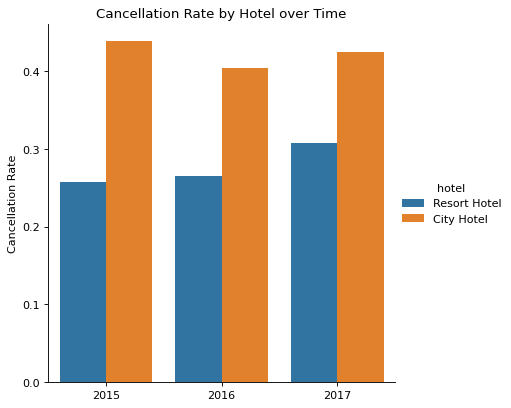

In [4]:
sns.catplot(
    data = d,
    x = "arrival_date_year",
    y = "is_canceled",
    hue = "hotel",
    kind = "bar",
    ci = False
).set(title='Cancellation Rate by Hotel over Time', 
      xlabel='', 
      ylabel='Cancellation Rate');

[ADD DESCIRPTION HERE]

[In my opinion this plot needs to be re-thought]

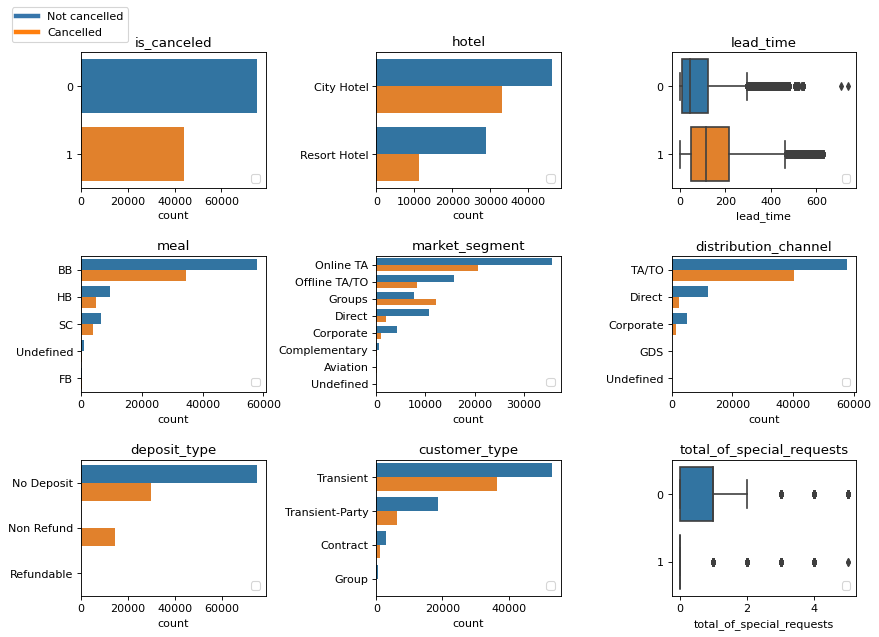

In [5]:
# Select columns for plotting
selected_cols = ['is_canceled', 'hotel', 'lead_time', 
                 'meal', 'market_segment', 'distribution_channel', 
                 'deposit_type', 'customer_type', 'total_of_special_requests']

# Create plot
fig, axs = plt.subplots(3, 3, figsize = (12.5, 9), sharex=False, sharey=False, 
                        gridspec_kw={'hspace': 0.5, 'wspace': 0.6})

h = 0 # Initialise plot number for iteration below

for col in selected_cols:
    
    # row number
    i = h // 3
    # col number
    j = h % 3
    
    if col == 'is_canceled':
        sns.countplot(ax = axs[i,j], y = 'is_canceled', data = d)
        
    elif col != 'is_canceled':
        if d[col].dtypes == 'O':            
            sns.countplot(ax = axs[i,j], y = col, data = d, hue = 'is_canceled',
                          order = d[col].value_counts().sort_values(ascending=False)[:15].index.to_list())

        elif (d[col].dtypes == 'int64') | (d[col].dtypes == 'float64'):
            sns.boxplot(ax = axs[i,j], x = col, y = 'is_canceled', data = d, orient = 'h')
    
    axs[i,j].set_title(col);
    axs[i,j].set_ylabel(None);
    axs[i,j].legend('', loc = 'lower right');
    
    h += 1
    


custom_lines = [Line2D([0], [0], color='#3776ab', lw=4),
                Line2D([0], [0], color='#ff7f0e', lw=4)]

fig.legend(custom_lines, ['Not cancelled', 'Cancelled'], loc = 'upper left', bbox_to_anchor = (0.05, 0.95))

plt.show();

### Excluding Implausible Observations
An important step in data cleaning is remove faulty data. In real-world applications data may be faulty for a number of reasons, input errors or technical problems when transferring the data from the hotel management software to the .csv file used here. It is therefore essential to critically evaluate the quality of each observation and treat implausible cases. We developed several flags that would indicate critical issues with the information.   

#### Guest Flags
An initial check on our data to decide if a given booking was valid or not was to check that there were the correct number of guests on a booking. This first involved removing bookings with no guests at all (184). We then proceeded to remove all bookings which contain no adults as we thought this unreasonable for children or babies to be making bookings without adults (223).

In [6]:
# Total guests 
d["n_guests"] = d.adults + d.children + d.babies

# Drop if no guests
d.drop(d[(d.n_guests < 1) | (np.isnan(d.n_guests))].index, inplace = True)

# Assume no children if `children` is nan
d['children'] = d['children'].fillna(0)

# Assume no babies if `babies` is nan
d['babies'] = d['babies'].fillna(0)

#drop entries with no adults
d = d[~(d.adults==0)]

Finally we decided to join the children and baby variable into a 'family' variable.

In [7]:
d['family'] = ((d['children'] > 0) | (d['babies'] > 0))

#### Price Flags
For the `adr` column, we removed rows with an Average Daily Rate of 0 as this would also be infeasible.

In [8]:
# drop entries with `adr` == 0
d = d[~(d.adr==0)]

We compute a price per person (ppp) to control for the size of a booking. Here adults and children are seen as paying customers.  

In [9]:
d["ppp"] = d.adr / (d.adults + d.children)

We can use this variable to examine the distribution of prices. We observe that there are two unreasonably expensive bookings which will be removed. 

In [10]:
print("Top 10 most expensive bookings per night per person:")
d.ppp.nlargest(10)

Top 10 most expensive bookings per night per person:


48515     2700.00
111403     510.00
68099      290.56
69796      289.88
110763     285.00
111441     285.00
111463     285.00
57595      279.20
67240      277.67
70681      277.15
Name: ppp, dtype: float64

In [11]:
# drop entries with `ppp` > 300
d = d[~(d.ppp>300)]

We can examine the distribution of prices after removing these outliers: We can observe that this distribution is centered around 50 with few cheaper stays and some more expensive stays forming a longer tail. This distribution appears reasonable. 

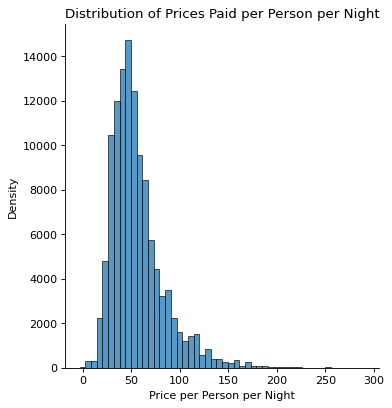

In [12]:
sns.displot(
    data = d,
    x = "ppp",
    kind = "hist",
    bins = 50
           ).set(title='Distribution of Prices Paid per Person per Night', 
      xlabel='Price per Person per Night', 
      ylabel='Density')

Further, we explored the average price by room type and observed that room L was assigned very few times and to an unreasonable price. Therefore, we decided to exclude bookings which reserved or were allocated to room L. 

In [13]:
round(d.groupby("assigned_room_type").ppp.mean().sort_values(),2)

assigned_room_type
L     4.00
I    45.95
C    47.79
H    52.35
B    55.42
A    55.47
D    55.72
G    59.16
F    60.26
E    61.59
K    65.20
Name: ppp, dtype: float64

In [14]:
d.drop(d[(d.assigned_room_type == "L")].index, inplace = True)
d.drop(d[(d.reserved_room_type == "L")].index, inplace = True)

#### Parking Spaces Flag
Seven more observations were excluded based on the number of requested parking spaces: We believe that bookings requiring more than one parking space per adult are unreasonable.

In [15]:
# drop entries with more than one car parking space requested per adult
d = d[~(d.required_car_parking_spaces/d.adults > 1)]

#### Total stay Flag 
We decided to combine the feature of stays in weekend and the week, for a total length of stay. Then we deleted the invalid rows which have a total stay of 0 nights.

In [16]:
# drop entries with zero weekend or weeknights stayed 
d["total_stay"] = d.stays_in_weekend_nights + d.stays_in_week_nights
d.drop(d[(d.total_stay < 1)].index, inplace = True)

#### Distribution Channel Flag
We found that there was only a single case with an undefined distribution channel. This was removed.  

In [17]:
# drop entries with undefined distribution channel
d[~(d.distribution_channel == "Undefined")]

,is_canceled,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,n_guests,family,ppp,total_stay
2,0,Resort Hotel,7,2015,July,27,1,0,1,1,...,NaN,0,Transient,75.00,0,0,1.0,False,75.000000,1
3,0,Resort Hotel,13,2015,July,27,1,0,1,1,...,NaN,0,Transient,75.00,0,0,1.0,False,75.000000,1
4,0,Resort Hotel,14,2015,July,27,1,0,2,2,...,NaN,0,Transient,98.00,0,1,2.0,False,49.000000,2
5,0,Resort Hotel,14,2015,July,27,1,0,2,2,...,NaN,0,Transient,98.00,0,1,2.0,False,49.000000,2
6,0,Resort Hotel,0,2015,July,27,1,0,2,2,...,NaN,0,Transient,107.00,0,0,2.0,False,53.500000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,0,City Hotel,23,2017,August,35,30,2,5,2,...,NaN,0,Transient,96.14,0,0,2.0,False,48.070000,7
119386,0,City Hotel,102,2017,August,35,31,2,5,3,...,NaN,0,Transient,225.43,0,2,3.0,False,75.143333,7
119387,0,City Hotel,34,2017,August,35,31,2,5,2,...,NaN,0,Transient,157.71,0,4,2.0,False,78.855000,7
119388,0,City Hotel,109,2017,August,35,31,2,5,2,...,NaN,0,Transient,104.40,0,0,2.0,False,52.200000,7


#### Agent and Company 
Antonio, Almeida and Nunes (2019) report that all the Nan values in the `company` and `agent` columns do not indicate missing data but rather 'does not apply'. This means that Nan values in these columns form a separate category 'no-company' and 'no-agent' respectively. Thus we replaced the Nan values accordingly with a new value.

In [18]:
# Fill nan's in the `agent` column with 536 (original range of codes for `agent` is 1 to 535)
d['agent'] = d['agent'].fillna(536)
# Fill nan's in the `company` column with 444 (original range of codes for `company` is 6 to 543)
d['company'] = d['company'].fillna(544)

Since the categorical company variable has too many levels, we decided to retain some information by creating a signle binary variable indicating whether or not this is a corporate booking.

In [19]:
d['is_company'] = np.where(d.company == 544, 1, 0)
d.drop("company", axis = "columns", inplace = True)

#### Checking Duplicates
It is important to explore and remove duplicates in the data as that would bias any subsequent analysis.

In [20]:
# add something here.

#### Country data
Literature discussing the data states that when customers do not enter their nationality, the country of the hotel (Portugal) is set by default. The nationality is then only corrected upon check-in. However, if customers cancel their information is never corrected. Therefore, the nationality data is inherently biased, including disproportionately many cancellations of Portuguese origin. Clearly, predictions can be improved by using this information, however, doing so would not generalise well to novel unbiased data. Therefore, we decided to not make use of the `country` column.  

In [21]:
d.drop(["country"], axis = "columns", inplace = True)

#### Assigned Rooms
Initially, we had created an indicator to show whether the reserved room matched the assigned room. This greatly improved predictions, specifically, guests were less likely to cancel if there was a mismatch. However, we believe that the assigned 
room is similarly biased like the country data. Specifically, we believe that rooms are assigned upon check-in, perhaps an upgrade is given. However, if the booking is cancelled, no changes will be made at check-in. Therefore, there are disproportionate amounts of cancellations when the assigned room matches the reserved room. To avoid any bias we decided not to use the assigned room variable. 

In [22]:
d.drop(["assigned_room_type"], axis = "columns", inplace = True)

### Feature Engineering
We have already engineered some variables in our flags above. Further features are engineered below.

#### Customer's lead time
Customer's lead time is the period between confirmation of the booking and arrival. Since lead time is large compared to the hotel's response time, this feature is heavily correlated with the original lead time. However, particularly for short-term bookings where quick confirmation may be important to customers, customer's lead time may provide valuable new information. 

Indeed, our results at the end of the paper show that this is a worthwhile variable to create, due to it's significance on the final prediction.

In [23]:
d["customers_lead"] = d.lead_time - d.days_in_waiting_list

### Relative Price per Person (Relative PPP)
Previously we obtained the price per person per night (PPP) which controls for both the number of guests and the duration of the stay. We believe, however, that an additional price-related metric may be of interest: The `relative_ppp` captures the relative price of a booking compared to other, similar bookings. The relative price therefore indicates whether a customer over- or underpaid for their stay. 

To calculate this measure it is first necessary to understand which variables affect price and should be considered when constructing the reference price. For instance, the top-left plot on the below image shows that prices differ significantly by hotel and season. Bookings should therefore only be compared to bookings made in the same hotel around a similar time. 

Similarly, lead time affects price as short-term bookings are typically more expensive than bookings made far in advance. The volatility in this plot is likely caused by not controlling for the previous factors (hotel and season) and also the sparse number of cases with long lead-times (>1 year). Indeed, the plot on the bottom left shows most medium-term bookings are made during peak-season. If this were controlled for, the trend would be even more pronounced. We decided to use a coarse grouping into short-term bookings (<50 days lead), medium-term (50 to 200 days) and long-term bookings with leads longer than that.   

Finally, we examined the price by room type. Interestingly, there is no pronounced trend as all rooms are similarly priced. When constructing the reference price, we therefore decided to disregard the reserved room.  

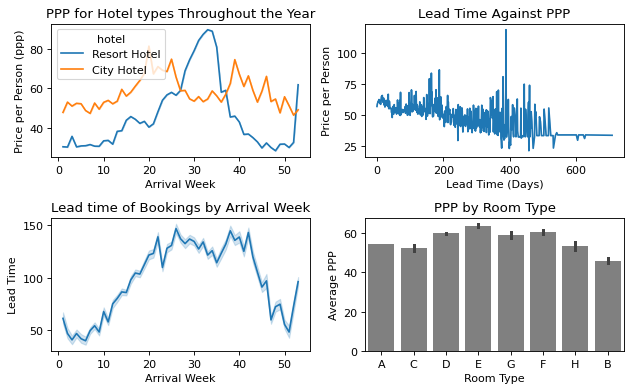

In [24]:
fig,axes = plt.subplots(2,2)

g1 = sns.lineplot(
    data = d,
    #x = "arrival_date_month",
    x = "arrival_date_week_number",
    y = "ppp",
    hue = "hotel",
    ci = False,
    ax=axes[0,0]).set(title = 'PPP for Hotel types Throughout the Year',xlabel = 'Arrival Week', ylabel = 'Price per Person (ppp)')

g2 = sns.lineplot(
    data = d,
    x = "lead_time",
    y = "ppp",
    ci = False,
    ax=axes[0,1]
           ).set(title = 'Lead Time Against PPP',ylabel = 'Price per Person', xlabel = 'Lead Time (Days)')

g3 = sns.lineplot(
    data = d,
    x = "arrival_date_week_number",
    y = "lead_time",
    ax=axes[1,0]).set(title = 'Lead time of Bookings by Arrival Week',ylabel='Lead Time',xlabel = 'Arrival Week')

g4 = sns.barplot(
    data = d,
    x = "reserved_room_type",
    y = "ppp",
    color = "grey"
           ).set(title='PPP by Room Type', 
      xlabel='Room Type', 
      ylabel='Average PPP')

#axes[0,0].set_xticklabels(["1","2","3","4","5","6","7","8","9","10","11","12"])
#axes[0,0].set_xticklabels(["1","2","3","4","5","6","7","8","9","10","11","12"])

plt.tight_layout()
plt.show()

Below, we computed the relative price by taking the average price in each group (by hotel, arrival month, and lead group) and dividing the price per person per night (ppp) of each booking by the relevant group. This provides a novel, interesting feature for further analysis.

In [25]:
# Creating a new variable that categorises lead time.
# This can later be used to group-by.
d["lead_cat"] = np.where(d.lead_time < 50, "short", np.where(d.lead_time < 200, "medium", "long"))

d.lead_cat
# Get the means for each type of booking
ppp_ref = d.groupby(["hotel", "arrival_date_month", "lead_cat"]).ppp.mean()
ppp_ref.columns = ['hotel', 'arrival_date_month', 'lead_cat']

ppp_ref = ppp_ref.reset_index()

ppp_actual = d[["hotel", "arrival_date_month", "lead_cat", "ppp"]]

# Create an ID column for the merge
ppp_ref["ppp_ID"] = ppp_ref["hotel"].astype(str) + ppp_ref["arrival_date_month"].astype(str) + ppp_ref["lead_cat"].astype(str)
ppp_actual["ppp_ID"] = ppp_actual["hotel"].astype(str) + ppp_actual["arrival_date_month"].astype(str) + ppp_actual["lead_cat"].astype(str)

# Drop unnecessary columns from reference frame
ppp_ref.drop(["hotel", "arrival_date_month", "lead_cat"], axis = "columns", inplace = True)

# Merge the two data frames 
ppp_joined = pd.merge(ppp_actual, 
                     ppp_ref, 
                     on ='ppp_ID', 
                     how ='left')
# Computes the actual price relative to the expected (mean) price for a booking of that category
ppp_joined["relative_ppp"] = ppp_joined.ppp_y / ppp_joined.ppp_x

d.reset_index(inplace = True)

# We add the new column to the existing data frame
d["relative_ppp"] = ppp_joined.relative_ppp

C:\Users\Ellio\anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


#### Dropping irrelevant variables
We decided to drop the arrival year variables since identifying a yearly trend would not transfer to future bookings. The arrival month was dropped in favour of the more granular arrival week, whereas the arrival date of the month does not seem to add helpful information. Perhaps considering holidays would be helpful however that data was not readily available. Children and babies were dropped in favour of a family variable indicating the presence or absence of children or babies. We could drop the price related variables `adr` and `ppp` because these are better captured by the more comparable `relative_ppp`.    

In [26]:
d.columns

Index(['index', 'is_canceled', 'hotel', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'market_segment', 'distribution_channel', 'is_repeated_guest',
       'previous_cancellations', 'previous_bookings_not_canceled',
       'reserved_room_type', 'booking_changes', 'deposit_type', 'agent',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests', 'n_guests',
       'family', 'ppp', 'total_stay', 'is_company', 'customers_lead',
       'lead_cat', 'relative_ppp'],
      dtype='object')

In [27]:
d2 = d.drop(['arrival_date_year','arrival_date_month','arrival_date_day_of_month','children','babies','reserved_room_type','agent',
        'required_car_parking_spaces','n_guests','index','ppp','lead_cat','adr'], axis=1)
d2 = d2.loc[~(d.distribution_channel=='Undefined'),:]

## Model Fitting and Tuning

Initially, we explored three different types of models: decision tree, random forest, and logistic regression. 

To start with, the optimised decision tree had a depth of 13. On the other hand, the random forest containing 1000 trees had a depth of 31. Notably, cost-complexity pruning worsened both models, meaning it possibly resulted in underfitting, hence `ccp_alpha` was kept at 0. Subsequently, the AUCs for the two models were 0.881 and 0.923 respectively, with the random forest model showing a comparable performance with the results in Antonio, Nuno & De Almeida, Ana & Nunes, Luís. (2017), i.e. an AUC of 0.877 to 0.934. 

The remaining model, logistic regression, was optimised on the norms used in the penalisation, in addition to the (inverse of the) regularisation strengths (C). We experimented with no regularisation, as well as L1, L2, and the combined elastic-net regularisations. Regularisation improved performance slightly, hence we decided to experiment with different penalty terms. As a side note, different solvers had to be adopted for different penalty norms: `lbfgs` for no penalty, `liblinear` for L1 and L2, and `saga` for elasticnet. Ultimately, the optimized logistic model showed an AUC of 0.835. While this is worse than the decision tree and random forest it allows for greater interpretability. While trees are generally well explainable the considerable depth (13 levels) prevented straightforward inference. The logistic regression model was therefore chosen for the best tradeoff between interpretability and performance. 

In [28]:
d2.columns

Index(['is_canceled', 'hotel', 'lead_time', 'arrival_date_week_number',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'meal',
       'market_segment', 'distribution_channel', 'is_repeated_guest',
       'previous_cancellations', 'previous_bookings_not_canceled',
       'booking_changes', 'deposit_type', 'days_in_waiting_list',
       'customer_type', 'total_of_special_requests', 'family', 'total_stay',
       'is_company', 'customers_lead', 'relative_ppp'],
      dtype='object')

In [29]:
y = d2.is_canceled
X = pd.get_dummies(d2.drop(["is_canceled"], axis=1), drop_first=True)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = True, random_state=1)

In [ ]:
# Logistic Regression with elasticnet regularisation
pipeline = Pipeline([('StandardScaler', StandardScaler()), 
                     ('LogisticRegression', LogisticRegression(multi_class='ovr', solver='saga', 
                                                               max_iter=1000))])

params = {'LogisticRegression__C': [0.01, 0.1, 1, 10, 100, 200, 500, 
                                    1000, 2000, 5000, 10000, 100000],
          'LogisticRegression__penalty': ['elasticnet'], 
          'LogisticRegression__l1_ratio': [0.1, 0.25, 0.5, 0.75, 0.9]}

KF = KFold(n_splits = 5, shuffle = True, random_state = 1)

model_LR_elasticnet = GridSearchCV(pipeline, params, cv = KF, scoring = 'roc_auc').fit(X_train, y_train)

In [ ]:
print(model_LR_elasticnet.best_estimator_)
print(model_LR_elasticnet.best_score_)

In [ ]:
# Logistic Regression with l1 or l2 regularisation
pipeline = Pipeline([('StandardScaler', StandardScaler()), 
                     ('LogisticRegression', LogisticRegression(multi_class='ovr', solver='liblinear'))])

params = {'LogisticRegression__C': [0.01, 0.1, 1, 10, 100, 200, 500, 
                                    1000, 2000, 5000, 10000, 100000], 
          'LogisticRegression__penalty': ['l1', 'l2']}

KF = KFold(n_splits = 5, shuffle = True, random_state = 1)

model_LR = GridSearchCV(pipeline, params, cv = KF, scoring = 'roc_auc').fit(X_train, y_train)

In [ ]:
print(model_LR.best_estimator_)
print(model_LR.best_score_)

In [ ]:
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_train, model_LR.predict(X_train))/len(y_train), annot = True, cmap="Blues");
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Not Cancel', 'Cancel']); ax.yaxis.set_ticklabels(['Not Cancel', 'Cancel']);

The confusion matrix above concisely summarises the logistic classifier's training performance. We can see that 59% of total bookings are correctly classified as not likely to cancel and 21% of bookings are correctly classified as likely cancellations. Combined, this constitutes an overall accruacy of 80% meaning that 80% of bookings are correctly classified. Looking at the errors, we can see that that false positives are very low (despite the fair baseline balance of classes). This means that any booking predicted as a cancellation is likely to be true and can be trusted. Conversely, however, false negatives consitute 16% of all classifications. This means that a considerable proportion of cancellations is not identified by our classifier. This may seem poor, however, it is important to remember that there is always a trade-off between false positives and false negatives: Generally, as false negatives decrease, false positives will increase. We believe that false positives are more costly to the hotel than false negatives. This is because if a booking is considered likely to cancel, the hotel can re-sell that room. If the guest however does visit after all (i.e. false positive) the hotel is forced to hand out free upgrades or even turn a customer down if there is no spare capacity permanently damaging its reputation. Therefore, we emphasise low false positive rates.   

In [ ]:
plt.figure(figsize=(15,10))
# Logistic regression weights
model_LR_weights = pd.DataFrame({'Feature': X_train.columns, 
                                 'Weight': model_LR.best_estimator_.named_steps['LogisticRegression'].coef_[0], 
                                 'abs_weight': abs(model_LR.best_estimator_.named_steps['LogisticRegression'].coef_[0])})

# Sort weights by absolute values
model_LR_weights = model_LR_weights.sort_values(by='abs_weight', ascending=False).drop(['abs_weight'], axis=1)

# Specify colors for positive and negative values
colors = ['#ff7f0e' if x < 0 else '#3776ab' for x in model_LR_weights.Weight]

sns.barplot(y = 'Feature', x = 'Weight', data = model_LR_weights, palette = colors)
plt.show();

In the plot above we can see the importance and direction of all features included in the model. The firs couple of features are most interesting, showing that a customer's previous cancellation history is most predictive of future cancellations. Total special requests are also predictive, showing that the more special requests are made, the lower the likelihood of cancellations. Conversely, longer lead-times are likely to increase cancellations. Besides these significant predictors, it is also interesting to examine which aspects are considered less significant. In particular, unlike special requests, meal requests are not particularly relevant. Similarly, despite the significant seasonality, the arrival week on its own is also not a relevant predictor. And finally, the relative price is also not relevant for cancellation rates, indicating that customers are not price sensitive. Offering special discounts may therefore not entice customers to stay. Instead, the hotel may examine their pricing strategy, raising prices during periods of high demand as cancellations are unlikely to be affected.  

In [ ]:
print('CV-AUC:', "\t", round(roc_auc_score(y_train, model_LR.best_estimator_.predict(X_train)),3))
print('CV-Accuracy:', "\t", round(accuracy_score(y_train, model_LR.best_estimator_.predict(X_train)),3))
print('CV-Precision:', "\t", round(precision_score(y_train, model_LR.best_estimator_.predict(X_train)),3))
print("")

print('Test-AUC:', "\t", round(roc_auc_score(y_test, model_LR.best_estimator_.predict(X_test)),3))
print('Test-Accuracy:', "\t", round(accuracy_score(y_test, model_LR.best_estimator_.predict(X_test)),3))
print('Test-Precision: ', round(precision_score(y_test, model_LR.best_estimator_.predict(X_test)),3))

The above values concisely summarise the performance of our model on training and test data. We observe strong agreement between the cross-validated training values and the test performance. Moreover, the general AUC metric shows acceptable performance, however, the more specific accuracy and particularly precision metrics show strong performance.   

### Bootstrap Analysis: Obtaining Confidence in Our Performance

So far we have focused the reporting of errors using cross validation. This demonstrated the good performance of our model. However, we do not know the variance of this estimate with confidence. Resampling methods can help estimate this variance. Bootstrap analysis can provide a confidence interval around our error estimates. Specifically, by repeatedly resampling with replacement we generate many individual error estimates. We computed 100 such bootstrap estimates and used these to obtain a 95% confidence interval on the AUC. The resulting interval is very narrow indicating excellent reliability of our model. This is helpful because the hotel would like the model to maintain its good performance on novel data. 

In [ ]:
# Initializes a dataframe to take the bootstrap samples from
X_boot = X_train.copy()
X_boot["is_canceled"] = y_train

# Stores the bootstrap samples
boots = []

# Resamples the data with replacements
i = 1
while i <= 100:
    boots.append(utils.resample(X_boot, replace=True, n_samples=len(X_train), random_state=i, stratify=None))
    i += 1

# Stores the AUC for each bootstrap sample
boot_auc = []

# Obtains the AUC for each bootstrap sample 
# by predicting using our model 
i = 0
while i < len(boots):
    boot_auc.append(roc_auc_score(boots[i].is_canceled, model_LR.predict(boots[i].drop("is_canceled", axis = 1))))
    i += 1

# Obtains the 95% confident interval
conf_int = st.t.interval(0.95, len(boot_auc)-1, loc=np.mean(boot_auc), scale=st.sem(boot_auc))

print("The 95% confidence interval is:", round(conf_int[1]-conf_int[0],3))

## Discussion & Conclusions


Having explored numerous logistic models, decision trees and random forests, we decided a logistic model would best suit the task at hand. While the random forest has slightly superior performance with an AUC of 0.923, this gain outweighed by the much improved interpretability of the logistic model. The decision tree model was similarly too deep to interpret meaningfully or too unabalanced in its predictions, excessively minimizing false positives at the expense of false negatives. The logistic model on the other hand provides the best balance between performance and interpretability as well as false positive and false negative errors. 

Specifically, the logistic model achieves a cross-validated AUC of 0.835 which is comparable to Almeida, Antonio and Nunes' (2017a) results using the same data. Overall accuracy is 0.803 and precision is high as well at 0.851. This performance translates reasonably well to unseen test data, achieving a respectable test-AUC of 0.772. Bootstrapping was applied to add a 95% confidence interval on this estimate of the generalization error. Results indicate that the performance is stable with the 95%-CI being $\pm$ 0.001. This shows that the model we developed is both high-performing and reliable. It is worth noting that including the nationality and assigned room variables would improve the model but in fact this information is biased and was disregarded. Similarly, we decided to train a model that predicts both cancellations and non-cancellations reasonably well. If more emphasis were placed on one type of error, this could be improved considerably.

We believe the hotel managers will be particularly interested in three components. What proportion of cancellations is detected, to what extent can these predictions be trusted and finally, which actions should the hotel take. Our model is able to detect most albeit not all cancellations (57.9%). Cancellations that are predicted can, however, be trusted as precision is high (85.1%). This means that the hotel can confidently take mitigating actions: A low-risk low-impact strategy is to attempt to persuade customers which are predicted to cancel to stay. This can be done by offering discounts, upgrades or other special offers. This is low-risk because the investment is minor however also low-impact as many customers may be insensitive to price. Indeed, this is shown by our model as the rate of the booking and in particular the relative price compared to similar bookings is not a significant factor in cancellations. Particularly during periods of high demand, hotels should instead develop their overbooking strategy. This entails offering rooms of customers likely to cancel. Thereby, hotel can effectively prevent revenue loss due to empty rooms. This is however more risky as having insufficient capacity to serve all overbooked customers will result in high costs such as loss of customer loyalty. Therefore, we emphasise that high accuracy is important and allows for such a risky strategy to be taken confidently. 

Finally, the hotel may benefit from understanding what drives cancellations and which long-term strategic changes can be applied to prevent cancellations in future. Our model provides insight to this question as well. Specifically, customers' cancellation history is a the most significant predictor. Sensibly, customers who have cancelled bookings before are likely to do so again and those that have a history of not cancelling their bookings are likely to continue this trend. Hotels should therefore focus their promotions on loyal customers rather than trying to capture customers that have cancelled in the past. Interestingly, non-refundable bookings are more likely to be cancelled. This is counterintuitive and may be better explained by a third factor which distuishes non-refundable bookings from refundable ones. Moreover, as customers' lead-time increases so does the likelihood of a cancellation while cancellations decrease as customers make more special requests. Hotels should therefore possibly limit the period of time customers can book rooms in advance, or send intermittent reminders of their booking. Perhaps asking for special requests closer to the stay can help increase engagement. Finally, it is also interesting to observe which variables are not related to cancellations. Specifically, cancellations are not seasonal and not price sensitive. Hotels can therefore benefit from increasing prices during peak season without fearing increased cancellations.  

In conclusion, we believe that our model is an effective tool to help hotels predict whether individual customers are likely to cancel. Targeted promotional activities can then be applied. Similarly, the hotel can better understand the number of total cancellations and develop a data-driven overbooking strategy to prevent empty rooms. Finally, long-term strategic changes may allow the hotel to prevent cancellations in future. Thus, we believe our model will likely help the hotel gain a competitive advantage.    

## References
Antonio, Nuno & De Almeida, Ana & Nunes, Luís. (2017). Predicting hotel bookings cancellation with a machine learning classification model, in: Proceedings of the 16th IEEE International Conference Machine Learning Application, IEEE, Cancun, Mexicopp. 1049–1054. doi:10.1109/ICMLA.2017.00-11.

Antonio, Nuno & De Almeida, Ana & Nunes, Luís. (2017). Predicting Hotel Booking Cancellation to Decrease Uncertainty and Increase Revenue. Tourism and Management Studies. 13. 25-39. 10.18089/tms.2017.13203.

Antonio, Nuno & De Almeida, Ana & Nunes, Luís. (2018). Hotel booking demand datasets. Data in Brief. 22. 41-49. 10.1016/j.dib.2018.11.126.

## Convert Document

In [ ]:
# Run the following to render to PDF
!jupyter nbconvert --to pdf proj2.ipynb